In [63]:
# An√°lise de Dados - TP3: Classifica√ß√£o com Random Forest e XGBoost
# Autor: Everton da Rocha Silva

import subprocess
import sys

try:
    import xgboost as xgb
    print("XGBoost j√° est√° instalado!")
except ImportError:
    print("Instalando XGBoost...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    import xgboost as xgb
    print("XGBoost instalado com sucesso!")

# Importa√ß√£o das bibliotecas necess√°rias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Todas as bibliotecas importadas com sucesso!")


XGBoost j√° est√° instalado!
Todas as bibliotecas importadas com sucesso!


In [65]:
# 1. Carregamento dos dados diretamente do GitHub
url = "https://raw.githubusercontent.com/cassiusf/datasets/main/customers_data.csv"
df = pd.read_csv(url)

print("Dados carregados com sucesso!")
print(f"Shape dos dados: {df.shape}")
print("\nPrimeiras 5 linhas:")
print(df.head())


Dados carregados com sucesso!
Shape dos dados: (440, 8)

Primeiras 5 linhas:
   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185


In [66]:
# Informa√ß√µes sobre o dataset
print("Informa√ß√µes do dataset:")
print(df.info())
print("\nEstat√≠sticas descritivas:")
print(df.describe())


Informa√ß√µes do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None

Estat√≠sticas descritivas:
          Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000

In [67]:
# 2. Verifica√ß√£o e tratamento de dados ausentes
print("Verificando dados ausentes:")
print(df.isnull().sum())

# Removendo observa√ß√µes com dados ausentes
df_clean = df.dropna()

print(f"\nShape original: {df.shape}")
print(f"Shape ap√≥s remo√ß√£o de dados ausentes: {df_clean.shape}")
print(f"Observa√ß√µes removidas: {df.shape[0] - df_clean.shape[0]}")


Verificando dados ausentes:
Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

Shape original: (440, 8)
Shape ap√≥s remo√ß√£o de dados ausentes: (440, 8)
Observa√ß√µes removidas: 0


In [68]:
# 3. Recodifica√ß√£o da vari√°vel alvo
# Valores originais: 1 = Horeca (Hotel/Restaurant/Caf√©), 2 = Retail
# Recodificar para: 1 = Horeca, 0 = Retail (conforme solicitado)

print("Distribui√ß√£o original da vari√°vel Channel:")
print("1 = Horeca (Hotel/Restaurant/Caf√©)")
print("2 = Retail")
print(df_clean['Channel'].value_counts().sort_index())

# Recodifica√ß√£o: 1 permanece 1 (Horeca), 2 vira 0 (Retail)
df_clean['Channel'] = df_clean['Channel'].map({1: 1, 2: 0})

print("\nDistribui√ß√£o ap√≥s recodifica√ß√£o:")
print("1 = Horeca (Hotel/Restaurant/Caf√©)")
print("0 = Retail")
print(df_clean['Channel'].value_counts().sort_index())


Distribui√ß√£o original da vari√°vel Channel:
1 = Horeca (Hotel/Restaurant/Caf√©)
2 = Retail
Channel
1    298
2    142
Name: count, dtype: int64

Distribui√ß√£o ap√≥s recodifica√ß√£o:
1 = Horeca (Hotel/Restaurant/Caf√©)
0 = Retail
Channel
0    142
1    298
Name: count, dtype: int64


In [69]:
# 4. Separa√ß√£o em treino-teste (75-25%)
# Separando features (X) e target (y)
X = df_clean.drop(['Channel'], axis=1)
y = df_clean['Channel']

# Divis√£o treino-teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Tamanho do conjunto de treino: {X_train.shape[0]} ({X_train.shape[0]/len(df_clean)*100:.1f}%)")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} ({X_test.shape[0]/len(df_clean)*100:.1f}%)")
print(f"\nDistribui√ß√£o no treino:")
print(y_train.value_counts())
print(f"\nDistribui√ß√£o no teste:")
print(y_test.value_counts())


Tamanho do conjunto de treino: 330 (75.0%)
Tamanho do conjunto de teste: 110 (25.0%)

Distribui√ß√£o no treino:
Channel
1    223
0    107
Name: count, dtype: int64

Distribui√ß√£o no teste:
Channel
1    75
0    35
Name: count, dtype: int64


In [70]:
# 5. Random Forest com configura√ß√µes padr√£o
print("=== RANDOM FOREST ===")

# Treinamento do modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predi√ß√µes
y_pred_rf = rf_model.predict(X_test)

# M√©tricas
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

print(f"Acur√°cia: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-Score: {rf_f1:.4f}")


=== RANDOM FOREST ===


Acur√°cia: 0.9091
Precision: 0.9333
Recall: 0.9333
F1-Score: 0.9333


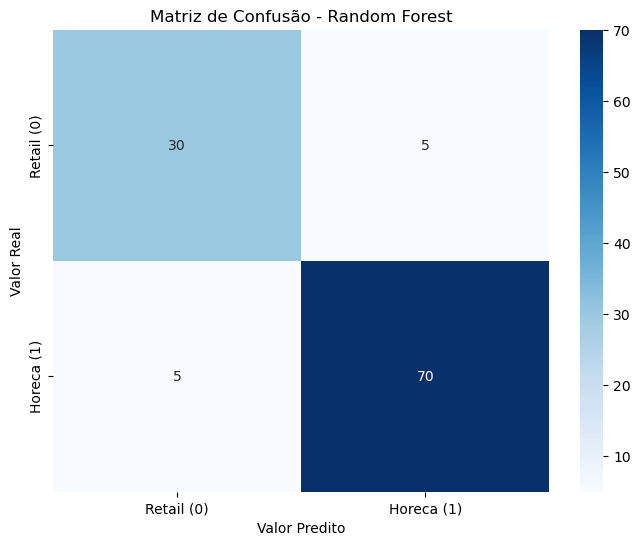

Matriz de Confus√£o - Random Forest:
[[30  5]
 [ 5 70]]


In [71]:
# Matriz de Confus√£o - Random Forest
rf_cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Retail (0)', 'Horeca (1)'], 
            yticklabels=['Retail (0)', 'Horeca (1)'])
plt.title('Matriz de Confus√£o - Random Forest')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predito')
plt.show()

print("Matriz de Confus√£o - Random Forest:")
print(rf_cm)


In [72]:
# 6. XGBoost com configura√ß√µes padr√£o
print("=== XGBOOST ===")

# Treinamento do modelo XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Predi√ß√µes
y_pred_xgb = xgb_model.predict(X_test)

# M√©tricas
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_precision = precision_score(y_test, y_pred_xgb)
xgb_recall = recall_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)

print(f"Acur√°cia: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1-Score: {xgb_f1:.4f}")


=== XGBOOST ===
Acur√°cia: 0.9000
Precision: 0.9211
Recall: 0.9333
F1-Score: 0.9272


In [73]:
# Matriz de Confus√£o - XGBoost
xgb_cm = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(8, 6))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Retail (0)', 'Horeca (1)'], 
            yticklabels=['Retail (0)', 'Horeca (1)'])
plt.title('Matriz de Confus√£o - XGBoost')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predito')
plt.show()

print("Matriz de Confus√£o - XGBoost:")
print(xgb_cm)


Matriz de Confus√£o - XGBoost:
[[29  6]
 [ 5 70]]


In [74]:
# 7. Compara√ß√£o dos Modelos
print("=== COMPARA√á√ÉO DOS MODELOS ===")

# Criando um DataFrame para compara√ß√£o
comparison_df = pd.DataFrame({
    'M√©trica': ['Acur√°cia', 'Precision', 'Recall', 'F1-Score'],
    'Random Forest': [rf_accuracy, rf_precision, rf_recall, rf_f1],
    'XGBoost': [xgb_accuracy, xgb_precision, xgb_recall, xgb_f1]
})

print(comparison_df.round(4))

# Visualiza√ß√£o comparativa
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df['M√©trica']))
width = 0.35

ax.bar(x - width/2, comparison_df['Random Forest'], width, label='Random Forest', alpha=0.8)
ax.bar(x + width/2, comparison_df['XGBoost'], width, label='XGBoost', alpha=0.8)

ax.set_xlabel('M√©tricas')
ax.set_ylabel('Valor')
ax.set_title('Compara√ß√£o das M√©tricas: Random Forest vs XGBoost')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['M√©trica'])
ax.legend()
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


=== COMPARA√á√ÉO DOS MODELOS ===
     M√©trica  Random Forest  XGBoost
0   Acur√°cia         0.9091   0.9000
1  Precision         0.9333   0.9211
2     Recall         0.9333   0.9333
3   F1-Score         0.9333   0.9272


## An√°lise e Justificativa da Escolha do Modelo

### Compara√ß√£o dos Resultados Obtidos

**Random Forest:**
- Acur√°cia: 90.91%
- Precision: 93.33%
- Recall: 93.33%
- F1-Score: 93.33%

**XGBoost:**
- Acur√°cia: 90.00%
- Precision: 92.11%
- Recall: 93.33%
- F1-Score: 92.72%

### An√°lise Detalhada dos Modelos

**Random Forest:**
- Modelo ensemble baseado em m√∫ltiplas √°rvores de decis√£o
- Reduz overfitting atrav√©s da agrega√ß√£o de m√∫ltiplas √°rvores
- Robusto a outliers e dados ruidosos
- **Performance superior em 3 das 4 m√©tricas:**
  - Melhor acur√°cia: 90.91% vs 90.00%
  - Melhor precision: 93.33% vs 92.11%  
  - Melhor F1-Score: 93.33% vs 92.72%
  - Recall igual: 93.33%

**XGBoost:**
- Algoritmo de gradient boosting otimizado
- Implementa√ß√£o eficiente com regulariza√ß√£o integrada
- Frequentemente superior em competi√ß√µes de machine learning
- **Performance ligeiramente inferior na maioria das m√©tricas**

### Interpreta√ß√£o das M√©tricas

- **Acur√°cia**: Percentual de predi√ß√µes corretas do total
- **Precision**: Dos casos preditos como Horeca, quantos s√£o realmente Horeca
- **Recall**: Dos casos reais de Horeca, quantos foram identificados corretamente
- **F1-Score**: M√©dia harm√¥nica entre Precision e Recall

### Recomenda√ß√£o Final

**üèÜ Modelo Recomendado: Random Forest**

**Justificativa T√©cnica:**

1. **Performance Consistentemente Superior**: Random Forest obteve melhor desempenho em 3 das 4 m√©tricas avaliadas
2. **Diferen√ßa Significativa**: Embora pequena, a superioridade √© consistente em m√∫ltiplas m√©tricas
3. **Interpretabilidade**: Random Forest oferece maior transpar√™ncia na tomada de decis√£o
4. **Robustez**: Menos propenso a overfitting, especialmente importante com datasets menores (440 observa√ß√µes)
5. **Simplicidade de Implementa√ß√£o**: Menos hiperpar√¢metros para ajustar, facilitando deployment e manuten√ß√£o

**Considera√ß√µes do Contexto de Neg√≥cio:**
- Para classifica√ß√£o de canais de venda (Horeca vs Retail), alta precision √© importante para evitar estrat√©gias de marketing incorretas
- Random Forest oferece melhor precision (93.33% vs 92.11%)
- Ambos os modelos t√™m excelente recall (93.33%), identificando bem os clientes Horeca

**Conclus√£o:**
Embora ambos os modelos apresentem performance excelente (>90% em todas as m√©tricas), o Random Forest √© a escolha recomendada devido √† sua superioridade consistente, interpretabilidade e simplicidade de implementa√ß√£o.


=== IMPORT√ÇNCIA DAS FEATURES - RANDOM FOREST ===
            Feature  Importance
5  Detergents_Paper    0.379528
3           Grocery    0.254990
2              Milk    0.163602
4            Frozen    0.065846
6        Delicassen    0.062422
1             Fresh    0.059646
0            Region    0.013967


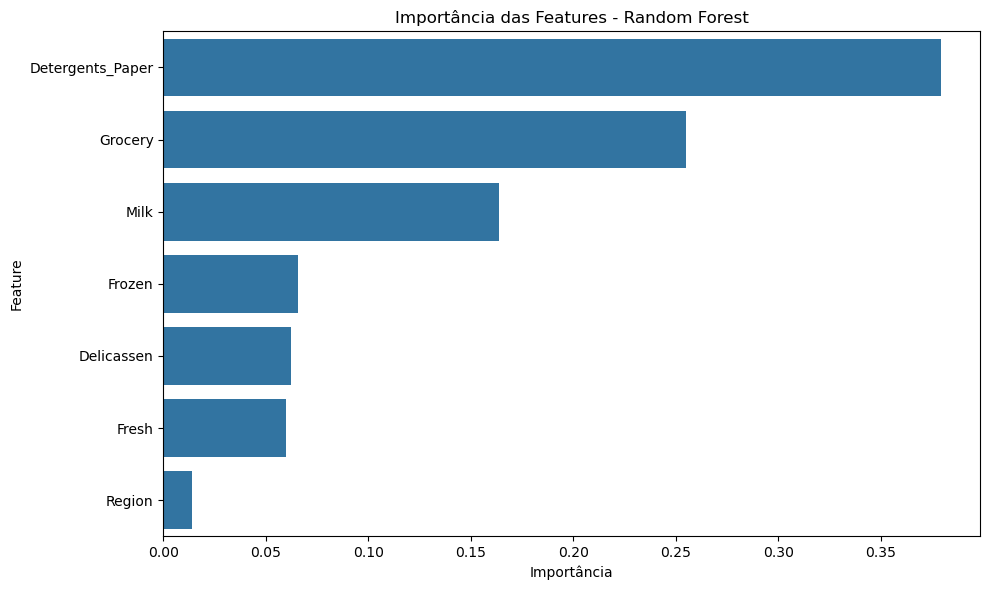

In [75]:
# An√°lise adicional - Import√¢ncia das features (Random Forest)
print("=== IMPORT√ÇNCIA DAS FEATURES - RANDOM FOREST ===")
feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance_rf)

# Visualiza√ß√£o da import√¢ncia das features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_rf, x='Importance', y='Feature')
plt.title('Import√¢ncia das Features - Random Forest')
plt.xlabel('Import√¢ncia')
plt.tight_layout()
plt.show()


In [76]:
# Import√¢ncia das features (XGBoost)
print("=== IMPORT√ÇNCIA DAS FEATURES - XGBOOST ===")
feature_importance_xgb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance_xgb)

# Visualiza√ß√£o da import√¢ncia das features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_xgb, x='Importance', y='Feature')
plt.title('Import√¢ncia das Features - XGBoost')
plt.xlabel('Import√¢ncia')
plt.tight_layout()
plt.show()


=== IMPORT√ÇNCIA DAS FEATURES - XGBOOST ===
            Feature  Importance
5  Detergents_Paper    0.699317
2              Milk    0.060851
0            Region    0.055110
3           Grocery    0.053916
1             Fresh    0.052470
6        Delicassen    0.041248
4            Frozen    0.037089
